In [1]:
# Mount Google Drive and import required libraries
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path

# Define base directories
BASE_DIR = Path('/content/drive/MyDrive/Cal_Estimation_Project/data')
PROCESSED_DIR = BASE_DIR / 'processed'
OUTPUT_DIR = BASE_DIR / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

print("Environment setup complete and Drive mounted.")


Mounted at /content/drive
Environment setup complete and Drive mounted.


In [2]:
# ============================================================
# CACHE UTILITIES FOR NOTEBOOK 03 (NEW)
# ============================================================

import pickle
import os

CACHE_DIR = "/content/drive/MyDrive/Cal_Estimation_Project/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_cache(obj, name="03_cache"):
    path = f"{CACHE_DIR}/{name}.pkl"
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"✔ Saved cache → {path}")

def load_cache(name="03_cache"):
    path = f"{CACHE_DIR}/{name}.pkl"
    if os.path.exists(path):
        print(f"✔ Loaded cache → {path}")
        with open(path, "rb") as f:
            return pickle.load(f)
    return None


In [3]:
# Load processed datasets from Notebook 02
foodseg = np.load(PROCESSED_DIR / 'foodseg103_samples.npz', allow_pickle=True)
nutrition5k = np.load(PROCESSED_DIR / 'nutrition5k_samples.npz', allow_pickle=True)
usda = pd.read_csv(PROCESSED_DIR / 'usda_reference.csv')

print("Datasets loaded successfully:\n")
print(f"FoodSeg103 → Images: {len(foodseg['images'])}, Masks: {len(foodseg['masks'])}")
print(f"Nutrition5k → RGB: {len(nutrition5k['rgb'])}, Depth: {len(nutrition5k['depth'])}")
print(f"USDA → Rows: {usda.shape[0]}, Columns: {usda.shape[1]}")


Datasets loaded successfully:

FoodSeg103 → Images: 50, Masks: 50
Nutrition5k → RGB: 5, Depth: 5
USDA → Rows: 135, Columns: 6


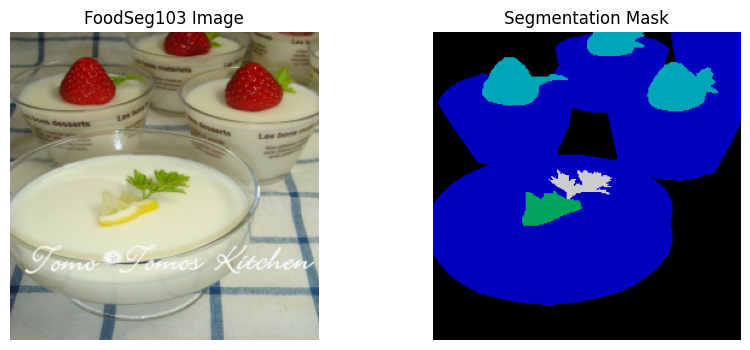

In [4]:
# Display a FoodSeg103 image and its segmentation mask
idx = random.randint(0, len(foodseg['images']) - 1)
img = foodseg['images'][idx]
mask = foodseg['masks'][idx]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("FoodSeg103 Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='nipy_spectral')
plt.title("Segmentation Mask")
plt.axis("off")
plt.show()


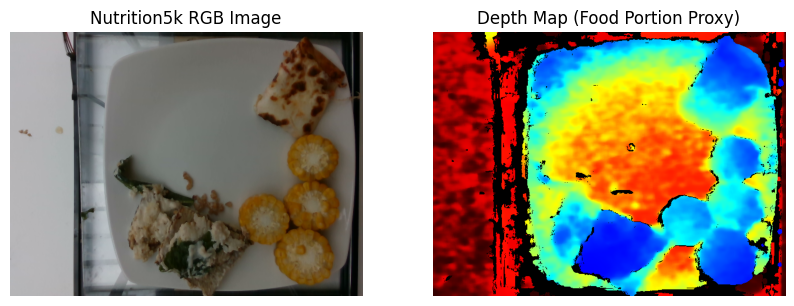

In [5]:
# Display a Nutrition5k RGB and Depth pair
idx = random.randint(0, len(nutrition5k['rgb']) - 1)
rgb = nutrition5k['rgb'][idx]
depth = nutrition5k['depth'][idx]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title("Nutrition5k RGB Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(depth, cmap='gray')
plt.title("Depth Map (Food Portion Proxy)")
plt.axis("off")
plt.show()


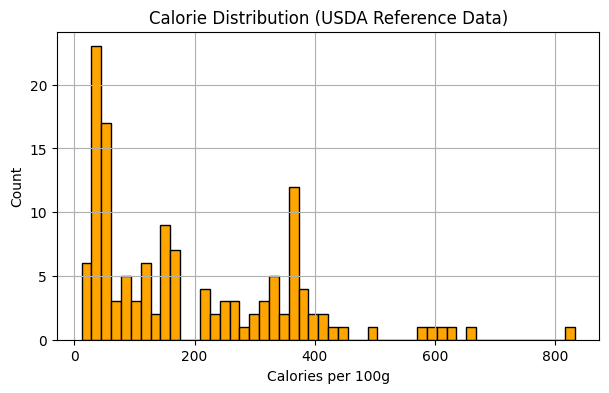

📊 Nutrient Summary Statistics:
       calories_kcal   protein_g       fat_g     carbs_g
count     135.000000  135.000000  135.000000  135.000000
mean      194.149916   11.777185    9.373481   16.017111
std       165.669981   12.589173   15.148370   23.864253
min        11.975150    0.000000    0.000000    0.000000
25%        52.540660    1.130000    0.340000    2.070000
50%       147.733351    7.810000    2.300000    6.020000
75%       326.621595   19.300000   11.500000   15.750000
max       832.370440   79.900000   99.100000   99.600000


In [6]:
# Visualize calorie distribution and show nutrient statistics
plt.figure(figsize=(7,4))
usda['calories_kcal'].dropna().hist(bins=50, color='orange', edgecolor='black')
plt.title("Calorie Distribution (USDA Reference Data)")
plt.xlabel("Calories per 100g")
plt.ylabel("Count")
plt.show()

print("📊 Nutrient Summary Statistics:")
print(usda[['calories_kcal', 'protein_g', 'fat_g', 'carbs_g']].describe())


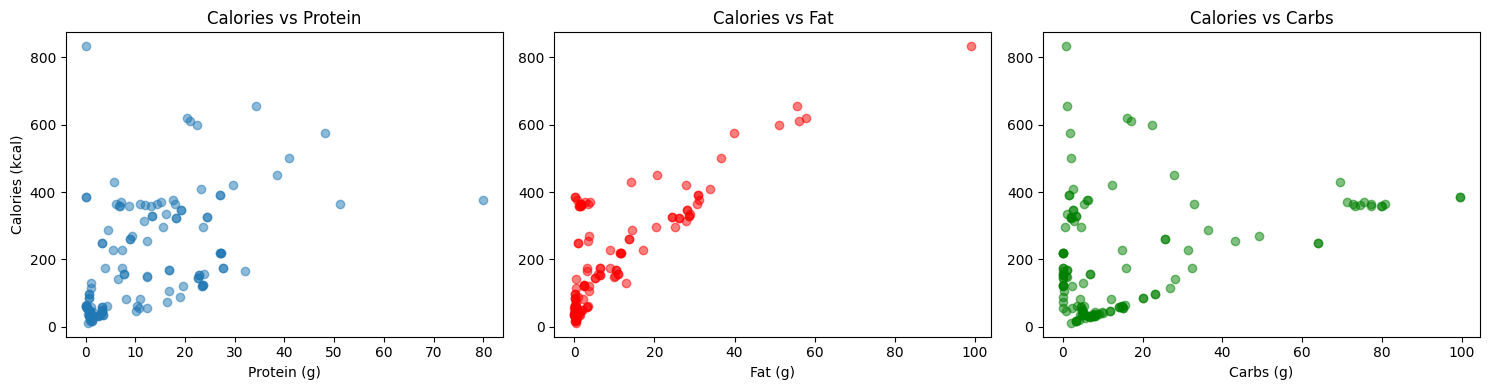

In [7]:
# Scatterplots showing how calories relate to protein, fat, and carbs
fig, axes = plt.subplots(1,3,figsize=(15,4))

axes[0].scatter(usda['protein_g'], usda['calories_kcal'], alpha=0.5)
axes[0].set_title("Calories vs Protein")
axes[0].set_xlabel("Protein (g)")
axes[0].set_ylabel("Calories (kcal)")

axes[1].scatter(usda['fat_g'], usda['calories_kcal'], alpha=0.5, color='red')
axes[1].set_title("Calories vs Fat")
axes[1].set_xlabel("Fat (g)")

axes[2].scatter(usda['carbs_g'], usda['calories_kcal'], alpha=0.5, color='green')
axes[2].set_title("Calories vs Carbs")
axes[2].set_xlabel("Carbs (g)")

plt.tight_layout()
plt.show()


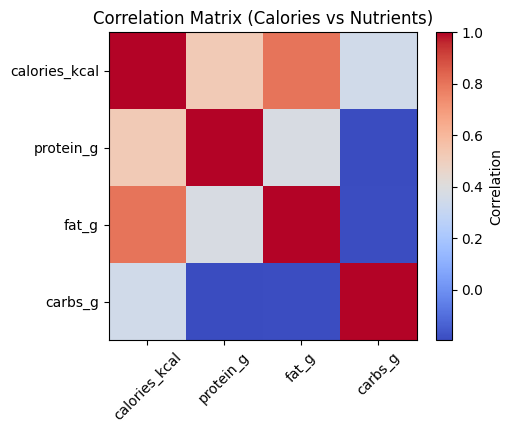

Correlation Values:
               calories_kcal  protein_g     fat_g   carbs_g
calories_kcal       1.000000   0.522581  0.800938  0.347715
protein_g           0.522581   1.000000  0.374535 -0.195509
fat_g               0.800938   0.374535  1.000000 -0.189496
carbs_g             0.347715  -0.195509 -0.189496  1.000000


In [8]:
# Display correlation heatmap among nutrients
corr = usda[['calories_kcal', 'protein_g', 'fat_g', 'carbs_g']].corr()

plt.figure(figsize=(5,4))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix (Calories vs Nutrients)")
plt.show()

print("Correlation Values:")
print(corr)


In [9]:
# Create feature and target variables for regression modeling
X = usda[['protein_g', 'fat_g', 'carbs_g']].fillna(0)
y = usda['calories_kcal'].fillna(0)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (135, 3)
Target vector shape: (135,)


In [10]:
# Train a baseline regression model using USDA nutrient data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Baseline Model Trained Successfully\n")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.2f} kcal per 100g")


Baseline Model Trained Successfully

R² Score: 0.997
Mean Absolute Error: 6.56 kcal per 100g


In [11]:
# Display learned coefficients for interpretability
coef_df = pd.DataFrame({
    'Nutrient': X.columns,
    'Coefficient (kcal per gram)': model.coef_.round(2)
}).sort_values('Coefficient (kcal per gram)', ascending=False)

print("Nutrient Contributions to Calorie Prediction:")
display(coef_df)


Nutrient Contributions to Calorie Prediction:


,Nutrient,Coefficient (kcal per gram)
1,fat_g,8.51
0,protein_g,4.43
2,carbs_g,3.92


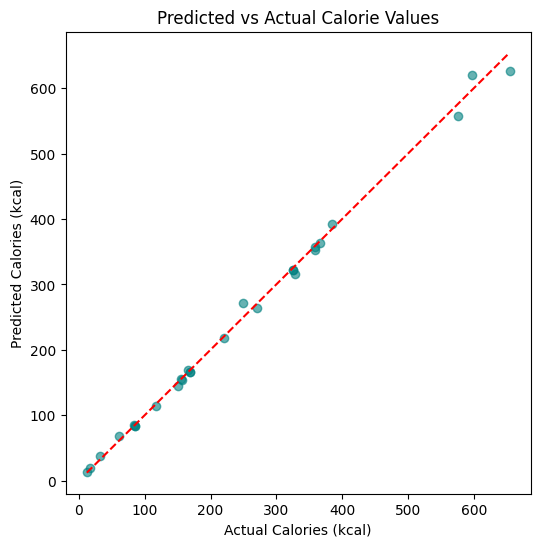

In [12]:
# Compare predicted vs actual calorie values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Calories (kcal)")
plt.ylabel("Predicted Calories (kcal)")
plt.title("Predicted vs Actual Calorie Values")
plt.show()


In [13]:
# Save baseline model coefficients
coef_df.to_csv(OUTPUT_DIR / 'baseline_model_coefficients.csv', index=False)
print("💾 Baseline model coefficients saved to /outputs/baseline_model_coefficients.csv")


💾 Baseline model coefficients saved to /outputs/baseline_model_coefficients.csv


In [14]:
# ============================================================
# SAVE CACHE FOR NOTEBOOK 03 (NEW)
# ============================================================

cache_data = {
    "coef_table_path": str(OUTPUT_DIR / "baseline_model_coefficients.csv"),
    "num_foodseg_samples": len(foodseg['images']),
    "num_nutrition5k_samples": len(nutrition5k['rgb']),
    "usda_rows": usda.shape[0]
}

save_cache(cache_data, "03_cache")


✔ Saved cache → /content/drive/MyDrive/Cal_Estimation_Project/cache/03_cache.pkl
